# Example 6: Solving Partial Differential Equation (PDE)

We aim to solve a 2D poisson equation $\nabla^2 f(x,y) = -2\pi^2{\rm sin}(\pi x){\rm sin}(\pi y)$, with boundary condition $f(-1,y)=f(1,y)=f(x,-1)=f(x,1)=0$. The ground truth solution is $f(x,y)={\rm sin}(\pi x){\rm sin}(\pi y)$.

In [1]:
from better_kan import KAN, LBFGS
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import numpy
import random
from torch import nn
torch.set_default_device('cuda')
dim = 2
np_i = 51 # number of interior points (along each dimension)
np_b = 51 # number of boundary points (along each dimension)
ranges = [-1, 1]


def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])

# interior
sampling_mode = 'mesh' # 'radnom' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)


alpha = 0.01
log = 1


steps = 100

pde_losses = []
bc_losses = []
l2_losses = []
class MLP(torch.nn.Module):
    def __init__(self, in_features, out_features, hidden_dim=128, num_layers=3, activation=torch.nn.SiLU(),seed=0):
        torch.manual_seed(seed)
        random.seed(seed)
        numpy.random.seed(seed)
        super(MLP, self).__init__()
        self.layers = nn.Sequential()
        self.layers.append(nn.Linear(in_features, hidden_dim))
        self.layers.append(activation)
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(activation)
        self.layers.append(nn.Linear(hidden_dim, out_features))
    def forward(self, x):
        return self.layers(x)
    def update_grid_from_samples(self, x, plot=True):
        pass
def size_of_model(model):
    size=0
    for p in model.parameters():
        size+=p.numel()*p.element_size()
    return size
def params_of_model(model):
    return size_of_model(model)/8

for hidden_dim in [128, 256, 512]:
    for activation in [torch.nn.SiLU(), torch.nn.ReLU()]:
        model=MLP(2,1,hidden_dim=hidden_dim,num_layers=4,activation=activation)
        def train():
            optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

            pbar = tqdm(range(steps), desc='description')
            print(x_i.shape)
            model.update_grid_from_samples(x_i,False)
            for _ in pbar:
                def closure():
                    global pde_loss, bc_loss
                    optimizer.zero_grad()
                    # interior loss
                    sol = sol_fun(x_i)
                    sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
                    sol_D1 = sol_D1_fun(x_i)
                    sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
                    lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
                    source = source_fun(x_i)
                    pde_loss = torch.mean((lap - source)**2)

                    # boundary loss
                    bc_true = sol_fun(x_b)
                    bc_pred = model(x_b)
                    bc_loss = torch.mean((bc_pred-bc_true)**2)

                    loss = alpha * pde_loss + bc_loss
                    loss.backward()
                    return loss

                # if _ % 5 == 0 and _ < 50:
                

                optimizer.step(closure)
                sol = sol_fun(x_i)
                loss = alpha * pde_loss + bc_loss
                l2 = torch.mean((model(x_i) - sol)**2)

                if _ % log == 0:
                    pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

                pde_losses.append(pde_loss.detach().cpu().numpy())
                bc_losses.append(bc_loss.detach().cpu().numpy())
                l2_losses.append(l2.detach().cpu().numpy())
            # model.plot()
            
        train()

description:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([2601, 2])


pde loss: 4.40e-04 | bc loss: 5.80e-07 | l2: 1.04e-07 : 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]
description:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([2601, 2])


pde loss: 9.36e+01 | bc loss: 5.45e-07 | l2: 2.41e-01 :  52%|█████▏    | 52/100 [00:08<00:07,  6.00it/s]

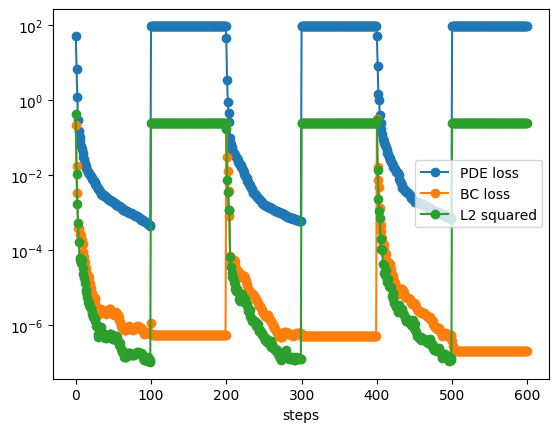

In [ ]:
plt.plot(pde_losses, marker='o')
plt.plot(bc_losses, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['PDE loss', 'BC loss', 'L2 squared'])